# 1 - BiLSTM pour Named Entity Recognition

## Introduction

Dans ce notebook, nous allons implémenter un modèle LSTM multi-couche et bidirectionnel pour faire de la reconnaissance d'entités nommés (ou NER) en utilisant le dataset CONLL2003.

## Préparer les données

On importe tout d'abord les librairies utiles.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchtext import data
from torchtext import datasets

import spacy
import numpy as np
import pandas as pd

import time
import random
import string
from itertools import chain

Les données sont téléchargeable [ici](https://github.com/davidsbatista/NER-datasets/tree/master/CONLL2003) au format .txt et sont sous la forme : 

```
-DOCSTART- -X- -X- O

SOCCER NN B-NP O
- : O O
JAPAN NNP B-NP B-LOC
GET VB B-VP O
LUCKY NNP B-NP O
WIN NNP I-NP O
, , O O
CHINA NNP B-NP B-PER
IN IN B-PP O
SURPRISE DT B-NP O
DEFEAT NN I-NP O
. . O O

Nadim NNP B-NP B-PER
Ladki NNP I-NP I-PER

AL-AIN NNP B-NP B-LOC
, , O O
United NNP B-NP B-LOC
Arab NNP I-NP I-LOC
Emirates NNPS I-NP I-LOC
1996-12-06 CD I-NP O
```

où les tags qui nous intéressent pour le named entity recognition sont ceux de la dernière colonne de chaque ligne. Par exemple, 0, B-LOC, B-PER ...

Nous allons arranger les données pour avoir une phrase par ligne et les convertir au format csv, pour qu'on puisse utiliser TorchText.

In [2]:
def process_doc(filename):
    data_test = []
    tag_test = []
    t = []
    sent = []
    label = []
    vocab = {}
    f1  = open(filename, "r") 
    for i, line in enumerate(f1):  
        if line.split(): #on ne prend pas en compte les listes vides
            vocab[line.split()[0]] = i
            sent.append(line.split()[0])
            tag = [s for s in line.split()[1:] if s not in string.punctuation]
            tag_test.append(tag[-1])
            t.append(tag[-1])

        else:
            if tag_test:
                label.append(" ".join(tag_test))
                tag_test = []
            if sent:
                data_test.append(" ".join(sent))
                sent = []
             
    return data_test, label

word_train, tag_train = process_doc('data_ner/train.txt')
word_val, tag_val = process_doc('data_ner/valid.txt')
word_test, tag_test = process_doc('data_ner/test.txt')


train = pd.DataFrame({'text':word_train, 'tag': tag_train})
validation = pd.DataFrame({'text':word_val, 'tag': tag_val})
test = pd.DataFrame({'text':word_test, 'tag': tag_test})

Nos données sont maintenant sous cette forme : 

In [3]:
train.head(7)

,text,tag
0,-DOCSTART-,O
1,EU rejects German call to boycott British lamb .,B-ORG O B-MISC O O O B-MISC O O
2,Peter Blackburn,B-PER I-PER
3,BRUSSELS 1996-08-22,B-LOC O
4,The European Commission said on Thursday it di...,O B-ORG I-ORG O O O O O O B-MISC O O O O O B-M...
5,Germany 's representative to the European Unio...,B-LOC O O O O B-ORG I-ORG O O O B-PER I-PER O ...
6,""" We do n't support any such recommendation be...",O O O O O O O O O O O O O O O O O O O O B-ORG ...


On les convertis en csv.

In [4]:
train.to_csv (r'data_ner/train.csv', index = False, header=True)
test.to_csv (r'data_ner/test.csv', index = False, header=True)
validation.to_csv (r'data_ner/valid.csv', index = False, header=True)

On a alors des données en forme pour pouvoir utiliser les méthodes de TorchText.

In [5]:
# pour la reproductibilité
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

On utilise la méthode `Field` de TorchText pour pré-traiter nos données. On utilise seulement `lower = True` pour mettre en minuscule le texte.

Pour les tags, on définit également un `Field`.

In [6]:
TEXT = data.Field(lower = True) 
TAG = data.Field(unk_token = None) # les tags sont tous connus on a alors unk_token = None

In [7]:
my_path = "data_ner/"
train_data, valid_data, test_data = data.TabularDataset.splits(
        path= my_path ,
        train="train.csv",
        validation="valid.csv",
        test="test.csv", format='csv', skip_header=True,
        fields=(("text", TEXT), ("tag", TAG))
    )

On affiche le nombre de phrases dans chaque dataset.

In [8]:
print(f"Number of training examples: {len(train_data)}")
print(f"Number of validation examples: {len(valid_data)}")
print(f"Number of testing examples: {len(test_data)}")

Number of training examples: 14986
Number of validation examples: 3465
Number of testing examples: 3683


Affichons un exemple.

In [9]:
print(vars(train_data.examples[3]))

{'text': ['brussels', '1996-08-22'], 'tag': ['B-LOC', 'O']}


Ensuite, nous construisons le vocabulaire.

On importe les embeddings pré-entrainés de [GloVe](https://nlp.stanford.edu/projects/glove/).  


`unk_init` est utilisé pour initialiser les embeddings qui ne sont pas dans le vocabulaire des embeddings pré-entraîné, on les initialise en utilisant une distribution Gaussienne.


In [10]:
MIN_FREQ = 0

TEXT.build_vocab(train_data, 
                 min_freq = MIN_FREQ, # les mots qui apparaissent moins que MIN_FREQ fois seront ignorés du vocabulaire
                 vectors = "glove.6B.300d",
                 unk_init = torch.Tensor.normal_)


TAG.build_vocab(train_data)

In [11]:
print(f"Unique tokens dans le vocabulaire de TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens dans le vocabulaire de TAG : {len(TAG.vocab)}")

Unique tokens dans le vocabulaire de TEXT vocabulary: 21012
Unique tokens dans le vocabulaire de TAG : 10


On peut afficher les tags les plus fréquents.

In [12]:
def tag_percentage(tag_counts):
    
    total_count = sum([count for tag, count in tag_counts])
    
    tag_counts_percentages = [(tag, count, count/total_count) for tag, count in tag_counts]
        
    return tag_counts_percentages

In [13]:
print("Tag\t\tCount\t\tPercentage\n")

for tag, count, percent in tag_percentage(TAG.vocab.freqs.most_common()):
    print(f"{tag}\t\t{count}\t\t{percent*100:4.1f}%")

Tag		Count		Percentage

O		170522		83.4%
B-LOC		7140		 3.5%
B-PER		6600		 3.2%
B-ORG		6319		 3.1%
I-PER		4528		 2.2%
I-ORG		3704		 1.8%
B-MISC		3438		 1.7%
I-LOC		1157		 0.6%
I-MISC		1155		 0.6%


On remarque que les tags ne sont pas équilibrés.

Enfin, la dernière étape de préparation des données et de créer des itérateurs.

In [33]:
BATCH_SIZE = 32

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    device = device, sort=False)

## Construire le modèle

On définit un modèle LSTM multi-couche et bi-directionnel. L'image ci-dessous illustre l'architecture de ce modèle de manière simplifiée.


![](https://github.com/bentrevett/pytorch-pos-tagging/blob/master/assets/pos-bidirectional-lstm.png?raw=1)

L'explication détaillée est décrite [ici](https://github.com/bentrevett/pytorch-pos-tagging/blob/master/1%20-%20BiLSTM%20for%20PoS%20Tagging.ipynb) ou dans [cet article](https://colah.github.io/posts/2015-08-Understanding-LSTMs/).

In [34]:
class BiLSTMNER(nn.Module):
    def __init__(self, 
                 input_dim, 
                 embedding_dim, 
                 hidden_dim, 
                 output_dim, 
                 n_layers, 
                 bidirectional, 
                 dropout, 
                 pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx = pad_idx)
        
        self.lstm = nn.LSTM(embedding_dim, 
                            hidden_dim, 
                            num_layers = n_layers, 
                            bidirectional = bidirectional,
                            dropout = dropout if n_layers > 1 else 0)
        
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):

        #text = [sent len, batch size]
        
        embedded = self.dropout(self.embedding(text)) 
        #embedded = [sent len, batch size, emb dim]
        
        outputs, (hidden, cell) = self.lstm(embedded)
        #output = [sent len, batch size, hid dim * n directions]
        #hidden/cell = [n layers * n directions, batch size, hid dim]
   
        predictions = self.fc(self.dropout(outputs))
        #predictions = [sent len, batch size, output dim]
        
        return predictions

## Entraînement

In [35]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 300 # doit être le même que la dimension du GloVe embeddings
HIDDEN_DIM = 128
OUTPUT_DIM = len(TAG.vocab)
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.25
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = BiLSTMNER(INPUT_DIM, 
                        EMBEDDING_DIM, 
                        HIDDEN_DIM, 
                        OUTPUT_DIM, 
                        N_LAYERS, 
                        BIDIRECTIONAL, 
                        DROPOUT, 
                        PAD_IDX)

On initialise les poids avec une disribution Gaussienne.

In [36]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.normal_(param.data, mean = 0, std = 0.1)
        
model.apply(init_weights)

BiLSTMNER(
  (embedding): Embedding(21012, 300, padding_idx=1)
  (lstm): LSTM(300, 128, num_layers=2, dropout=0.25, bidirectional=True)
  (fc): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

On affiche combien ce modèle a de paramètres.

In [37]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Le modèle a {count_parameters(model):,} paramètres à entraîner')

Le modèle a 7,141,754 paramètres à entraîner


On initialise la couche embedding du modèle avec les valeurs des embedding pré-entraînées importées précédemment.

In [38]:
pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-0.1117, -0.4966,  0.1631,  ..., -1.4447,  0.8402, -0.8668],
        [ 0.1032, -1.6268,  0.5729,  ...,  0.3180, -0.1626, -0.0417],
        [ 0.0466,  0.2132, -0.0074,  ...,  0.0091, -0.2099,  0.0539],
        ...,
        [-0.0349, -0.0862,  0.0485,  ..., -0.4713,  0.5426,  2.1263],
        [-0.0479,  0.9828,  0.9182,  ...,  0.0424,  0.4554, -0.3210],
        [-0.1881, -0.4332, -0.4754,  ...,  0.6583,  0.2311,  0.1486]])

On initialise également les embedding des tokens pad à zéro.

In [39]:
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

On définit ensuite l'optimiseur. On utilise Adam.

In [40]:
optimizer = optim.Adam(model.parameters())

La fonction de coût est la cross-entropy. Dans le vocabulaire de TAG, on a des tokens `<pad>` car dans un batch les phrases doivent avoir la même taille. En revanche, nous ne voulons par calculer la perte quand le tag vaut  `<pad>`, c'est pour cela qu'on doit les ignorer avec l'argument `ignore_index`.

In [22]:
TAG_PAD_IDX = TAG.vocab.stoi[TAG.pad_token]
criterion = nn.CrossEntropyLoss(ignore_index = TAG_PAD_IDX)

On place notre modèle et la fonction de coût sur GPU.

In [41]:
model = model.to(device)
criterion = criterion.to(device)

La fonction suivante calcule le f1 score en ne prenant pas en compte les tokens `<pad>`.

In [42]:
from sklearn.metrics import f1_score

def f1_loss(preds, y, tag_pad_idx):
    index_o = TAG.vocab.stoi["O"]
    positive_labels = [i for i in range(len(TAG.vocab.itos))
                           if i not in (tag_pad_idx, index_o)]
    _, pred = torch.max(preds, 1)
    pred = pred.data.cpu().numpy() 
    tags = y.data.cpu().numpy()
    f1 = f1_score(
            y_true=tags,
            y_pred=pred,
            labels=positive_labels,
            average="micro"
        ) 
       
    return f1

On crée une fonction qui nous donne l'accuracy par tag.

In [43]:
def accuracy_per_tag(predictions, tags):
    n_tags = len(TAG.vocab)
    class_correct = list(0 for i in range(n_tags))
    class_total = list(0 for i in range(n_tags))
    acc = list(0 for i in range(n_tags))
    _, pred = torch.max(predictions, 1)
    # # compare predictions to true label
    correct = np.squeeze(pred.eq(tags.data.view_as(pred)))
    # # calculate test accuracy for each object class
    for i in range(len(tags.data)):
        label = tags.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
    for i in range(n_tags):
        if np.sum(class_total[i]) == 0 and np.sum(class_correct[i]) ==0:
            res = 0
        else:
            res = 100 * class_correct[i] / class_total[i]
        acc[i] = res, np.sum(class_correct[i]), np.sum(class_total[i])
        
    return acc        

Vient ensuite la fonction qui gère l'entraînement de notre modèle.

Nous avons d'abord mis le modèle en mode `train` pour activer le dropout / batch-normarlization (si utilisé). Ensuite, nous itérons sur notre itérateur, qui renvoie un batch d'exemples.

Pour chaque batch:
- on remet à zéro les gradients sur les paramètres du dernier calcul de gradient
- insérez le batch de texte dans le modèle pour obtenir des prédictions
- comme les fonctions de perte de PyTorch ne peuvent pas gérer les prédictions en 3 dimensions, nous redimensionnons nos prédictions
- calculer la perte et la précision entre les tags prédits et les tags réels
- appeler `backward` pour calculer les gradients des paramètres w.r.t. la perte
- effectuez une «step» d'optimisation pour mettre à jour les paramètres

In [44]:
def train(model, iterator, optimizer, criterion, tag_pad_idx):
    
    
    epoch_loss = 0
    epoch_f1 = 0
    acc = []  
    model.train()
    
    for batch in iterator:
        
        text = batch.text
        tags = batch.tag
        
        optimizer.zero_grad()

        predictions = model(text)
 
        predictions = predictions.view(-1, predictions.shape[-1])
        tags = tags.view(-1)
        
    
        loss = criterion(predictions, tags)
        acc.append(accuracy_per_tag(predictions, tags))
        f1 = f1_loss(predictions, tags, tag_pad_idx)
        
        loss.backward()
        
        optimizer.step()


        epoch_loss += loss.item()
        epoch_f1 += f1.item()
        
    return epoch_loss / len(iterator), acc, epoch_f1 / len(iterator)

La fonction `evaluer` est similaire à la fonction` train`, sauf avec les modifications apportées afin de ne pas mettre à jour les paramètres du modèle.

`model.eval ()` est utilisé pour mettre le modèle en mode évaluation, donc dropout / batch-norm / etc. sont désactivés.

La boucle d'itération est également enveloppée dans `torch.no_grad` pour nous assurer que nous ne calculons aucun gradient. Nous n'avons pas non plus besoin d'appeler `optimizer.zero_grad ()` et `optimizer.step ()`.

In [45]:
def evaluate(model, iterator, criterion, tag_pad_idx):
    
    epoch_loss = 0
    epoch_f1 = 0
    acc = []
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text = batch.text
            tags = batch.tag
            
            predictions = model(text)
            
            predictions = predictions.view(-1, predictions.shape[-1])
            tags = tags.view(-1)
            
            loss = criterion(predictions, tags)
            
            acc.append(accuracy_per_tag(predictions,tags))
            f1 = f1_loss(predictions, tags, tag_pad_idx)
            
            epoch_loss += loss.item()
            epoch_f1 += f1.item()
        
    return epoch_loss / len(iterator), acc, epoch_f1 / len(iterator)

On affiche la perte et le f1 score à chaque époque, ainsi que le temps d'exécution.

In [46]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

N_EPOCHS = 5

t_loss = []
t_f1 = []
v_loss = []
v_f1 = []

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc, train_f1 = train(model, train_iterator, optimizer, criterion, TAG_PAD_IDX)
    t_loss.append(train_loss)
    t_f1.append(train_f1)  
    
    valid_loss, valid_acc, valid_f1 = evaluate(model, valid_iterator, criterion, TAG_PAD_IDX)
    v_loss.append(valid_loss)
    v_f1.append(valid_f1)   
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    

    if epoch%2 == 0: 
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train F1 score: {train_f1*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. F1 score: {valid_f1*100:.2f}%')

Epoch: 01 | Epoch Time: 8m 5s
	Train Loss: 0.281 | Train F1 score: 64.23%
	 Val. Loss: 0.176 |  Val. F1 score: 76.52%
Epoch: 03 | Epoch Time: 14m 49s
	Train Loss: 0.061 | Train F1 score: 91.31%
	 Val. Loss: 0.131 |  Val. F1 score: 82.53%
Epoch: 05 | Epoch Time: 24m 22s
	Train Loss: 0.028 | Train F1 score: 95.07%
	 Val. Loss: 0.152 |  Val. F1 score: 81.00%


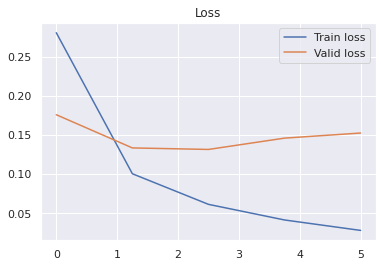

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np 
sns.set()

x = np.linspace(0, N_EPOCHS,N_EPOCHS)

plt.plot(x,t_loss)
plt.plot(x,v_loss)
plt.title("Loss")
plt.legend(["Train loss", "Valid loss"])

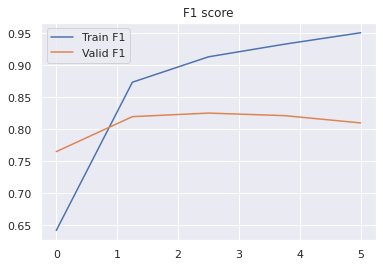

In [48]:
x = np.linspace(0, N_EPOCHS,N_EPOCHS)

plt.plot(x,t_f1)
plt.plot(x,v_f1)
plt.title("F1 score")
plt.legend(["Train F1", "Valid F1"])

In [49]:
n = len(train_acc) - 2
n_tags = len(TAG.vocab)
for i in range(n_tags):   
    print('Train Accuracy of %5s: %2d%% (%2d/%2d)' % (
           TAG.vocab.itos[i], train_acc[n][i][0],
           train_acc[n][i][1], train_acc[n][i][2]))  

Train Accuracy of <pad>:  0% ( 0/850)
Train Accuracy of     O: 99% (438/440)
Train Accuracy of B-LOC: 100% (21/21)
Train Accuracy of B-PER: 100% (20/20)
Train Accuracy of B-ORG: 92% (12/13)
Train Accuracy of I-PER: 100% (10/10)
Train Accuracy of I-ORG: 100% ( 6/ 6)
Train Accuracy of B-MISC: 70% ( 7/10)
Train Accuracy of I-LOC: 100% ( 4/ 4)
Train Accuracy of I-MISC: 100% ( 2/ 2)


In [50]:
n = len(valid_acc) - 2
for i in range(n_tags):
    print('Valid Accuracy of %5s: %2d%% (%2d/%2d)' % (
           TAG.vocab.itos[i], valid_acc[n][i][0],
           valid_acc[n][i][1], valid_acc[n][i][2]))

Valid Accuracy of <pad>:  0% ( 0/748)
Valid Accuracy of     O: 98% (600/607)
Valid Accuracy of B-LOC: 71% (10/14)
Valid Accuracy of B-PER: 23% ( 7/30)
Valid Accuracy of B-ORG: 40% ( 2/ 5)
Valid Accuracy of I-PER: 46% ( 6/13)
Valid Accuracy of I-ORG: 66% ( 2/ 3)
Valid Accuracy of B-MISC: 50% ( 5/10)
Valid Accuracy of I-LOC:  0% ( 0/ 1)
Valid Accuracy of I-MISC:  0% ( 0/ 9)


Nous chargeons nos meilleurs paramètres et évaluons sur les données test. 

In [51]:
model.load_state_dict(torch.load('tut1-model.pt'))

test_loss, test_acc, test_f1 = evaluate(model, test_iterator, criterion, TAG_PAD_IDX)
print(f'Test Loss: {test_loss:.3f} |  Test F1 score: {test_f1*100:.2f}%')

Test Loss: 0.220 |  Test F1 score: 75.63%


In [52]:
n = len(test_acc) - 2
for i in range(n_tags):   
    print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
           TAG.vocab.itos[i], test_acc[n][i][0],
           test_acc[n][i][1], test_acc[n][i][2]))


Test Accuracy of <pad>:  0% ( 0/1096)
Test Accuracy of     O: 98% (290/293)
Test Accuracy of B-LOC: 60% ( 3/ 5)
Test Accuracy of B-PER: 57% ( 4/ 7)
Test Accuracy of B-ORG: 81% (18/22)
Test Accuracy of I-PER: 100% ( 2/ 2)
Test Accuracy of I-ORG: 55% ( 5/ 9)
Test Accuracy of B-MISC: 50% ( 2/ 4)
Test Accuracy of I-LOC: 50% ( 1/ 2)
Test Accuracy of I-MISC:  0% ( 0/ 0)


## Inférence

Nous définissons une fonction `tag_sentence` qui va:
- mettre le modèle en mode évaluation
- tokenize la phrase avec spaCy si ce n'est pas une liste
- mettre en minuscule des tokens si le `Field` l'a fait
- numériser les tokens en utilisant le vocabulaire
- découvrir quels tokens ne sont pas dans le vocabulaire, c'est-à-dire sont des tokens `<unk>`
- convertir les tokens numérisés en un tenseur et ajouter une dimension de batch
- introduire le tenseur dans le modèle
- obtenir les prédictions sur la phrase
- convertir les prédictions en tags lisibles

En plus de renvoyer les tokens et les tags, il renvoie également les tokens qui étaient des jetons `<unk>`.

In [53]:
def tag_sentence(model, device, sentence, text_field, tag_field):
    
    model.eval()
    
    if isinstance(sentence, str):
        nlp = spacy.load('en')
        tokens = [token.text for token in nlp(sentence)]
    else:
        tokens = [token for token in sentence]

    if text_field.lower:
        tokens = [t.lower() for t in tokens]
        
    numericalized_tokens = [text_field.vocab.stoi[t] for t in tokens]

    unk_idx = text_field.vocab.stoi[text_field.unk_token]
    
    unks = [t for t, n in zip(tokens, numericalized_tokens) if n == unk_idx]
    
    token_tensor = torch.LongTensor(numericalized_tokens)
    
    token_tensor = token_tensor.unsqueeze(-1).to(device)
         
    predictions = model(token_tensor)
    
    top_predictions = predictions.argmax(-1)
    
    predicted_tags = [tag_field.vocab.itos[t.item()] for t in top_predictions]
    
    return tokens, predicted_tags, unks

On utilise un exemple du dataset train.

In [54]:
example_index = 39

sentence = vars(test_data.examples[example_index])['text']
actual_tags = vars(test_data.examples[example_index])['tag']

print(sentence)
print(actual_tags)

['two', 'goals', 'in', 'the', 'last', 'six', 'minutes', 'gave', 'holders', 'japan', 'an', 'uninspiring', '2-1', 'asian', 'cup', 'victory', 'over', 'syria', 'on', 'friday', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'O', 'O', 'B-MISC', 'I-MISC', 'O', 'O', 'B-LOC', 'O', 'O', 'O']


On utilise la fonction `tag_sentence` pour trouver les tags.

In [55]:
tokens, pred_tags, unks = tag_sentence(model, 
                                       device, 
                                       sentence, 
                                       TEXT, 
                                       TAG)
print(pred_tags)
print(actual_tags)

['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'O', 'O', 'B-MISC', 'I-MISC', 'O', 'O', 'B-LOC', 'O', 'O', 'O']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'O', 'O', 'B-MISC', 'I-MISC', 'O', 'O', 'B-LOC', 'O', 'O', 'O']


On vérifie alors si le modèle a correctement prédit les tags.

In [56]:
print("Pred. Tag\t\t\t\tActual Tag\t\t\tCorrect?\t\t\tToken\n")

for token, pred_tag, actual_tag in zip(tokens, pred_tags, actual_tags):
    correct = '✔' if pred_tag == actual_tag else '✘'
    print(f"{pred_tag}\t\t\t\t{actual_tag}\t\t\t{correct}\t\t\t{token}")

Pred. Tag				Actual Tag			Correct?			Token

O				O			✔			two
O				O			✔			goals
O				O			✔			in
O				O			✔			the
O				O			✔			last
O				O			✔			six
O				O			✔			minutes
O				O			✔			gave
O				O			✔			holders
B-LOC				B-LOC			✔			japan
O				O			✔			an
O				O			✔			uninspiring
O				O			✔			2-1
B-MISC				B-MISC			✔			asian
I-MISC				I-MISC			✔			cup
O				O			✔			victory
O				O			✔			over
B-LOC				B-LOC			✔			syria
O				O			✔			on
O				O			✔			friday
O				O			✔			.


Essayons avec notre propre phrase. La liste unks est nulle cela signifie que tous les mots de cette phrase sont dans le vocabulaire.

In [58]:
sentence = 'The will deliver a speech about the conflict in North Korea tomorrow in New York with my friend Mary Kate.'

tokens, tags, unks = tag_sentence(model, 
                                  device, 
                                  sentence, 
                                  TEXT, 
                                  TAG)

print(unks)

[]


In [59]:
print("Pred. Tag\tToken\n")

for token, tag in zip(tokens, tags):
    print(f"{tag}\t\t{token}")

Pred. Tag	Token

O		the
O		will
O		deliver
O		a
O		speech
O		about
O		the
O		conflict
O		in
B-LOC		north
I-LOC		korea
O		tomorrow
O		in
B-LOC		new
I-LOC		york
O		with
O		my
O		friend
B-PER		mary
I-PER		kate
O		.


## Références :

 - [pytorch-pos-tagging](https://github.com/bentrevett/pytorch-pos-tagging/blob/master/1%20-%20BiLSTM%20for%20PoS%20Tagging.ipynb)
 - [Understanding LSTM Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/).